In [1]:
import numpy as np

from glob import glob
from treem import SWC

In [2]:
mcells = glob('../data/mouse/derived/converted/*.swc')
hcells = glob('../data/human/derived/converted/*.swc')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
Set1 = mpl.colormaps.get_cmap('Set1')
Pastel1 = mpl.colormaps.get_cmap('Pastel1')
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)

In [5]:
def get_soma_contour(swc, point_type=17):
    data = np.loadtxt(swc)
    sel = (data[:, SWC.T] == point_type)
    contour = data[sel, SWC.XYZ]
    return contour

In [6]:
import open3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
def get_soma_dims(contour):
    center = np.mean(contour, axis=0)
    radii = np.linalg.norm(contour - center, axis=1)
    avg_diam = radii.mean() * 2
    
    flat = True if abs(contour[:,2].max() - contour[:,2].min()) < 5.0 else False
    if flat:
        from scipy.spatial.transform import Rotation as R
        rot = R.from_rotvec(np.pi/2 * np.array([0, 1, 0]))
        rotcont = rot.apply(contour)
        shift = np.mean(rotcont, axis=0) - center
        rotcont -= shift
        contour = np.concatenate((contour, rotcont), axis=0)
    
    points = open3d.utility.Vector3dVector(contour)
    obb = open3d.geometry.OrientedBoundingBox().create_from_points(points)
    max_diam = obb.extent[0]
    min_diam = obb.extent[2]

    return avg_diam, min_diam, max_diam

In [8]:
mdims = np.array([get_soma_dims(get_soma_contour(cell)) for cell in mcells])
hdims = np.array([get_soma_dims(get_soma_contour(cell)) for cell in hcells])

In [9]:
mdf = pd.DataFrame(mdims[:,0], columns=['radius'])
mdf['species'] = 'Mouse'

hdf = pd.DataFrame(hdims[:,0], columns=['radius'])
hdf['species'] = 'Human'

df = pd.concat([mdf, hdf])

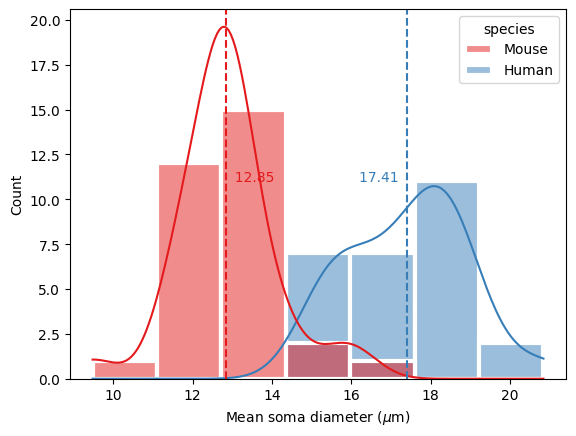

In [10]:
ax = sns.histplot(df, x='radius', hue='species', kde=True, 
                  palette=[mcolor, hcolor], ec='w', linewidth=3)
mdiam = mdims[:,0].mean()
hdiam = hdims[:,0].mean()
ax.axvline(mdiam, linestyle='--', color=mcolor)
ax.axvline(hdiam, linestyle='--', color=hcolor)
ax.text(mdiam, 11, f'  {mdiam:.2f}', color=mcolor, ha='left')
ax.text(hdiam, 11, f'{hdiam:.2f}  ', color=hcolor, ha='right')
ax.set_xlabel('Mean soma diameter ($\mu$m)')
plt.savefig('images/somata-1.pdf')

In [11]:
mdims[:,0].mean(), mdims[:,1].min(), mdims[:,2].max(), len(mdims)

(12.851568434431064, 6.50923288020935, 16.839400078139377, 31)

In [12]:
hdims[:,0].mean(), hdims[:,1].min(), hdims[:,2].max(), len(hdims)

(17.410404830881184, 9.747606005837486, 21.9644234066688, 27)

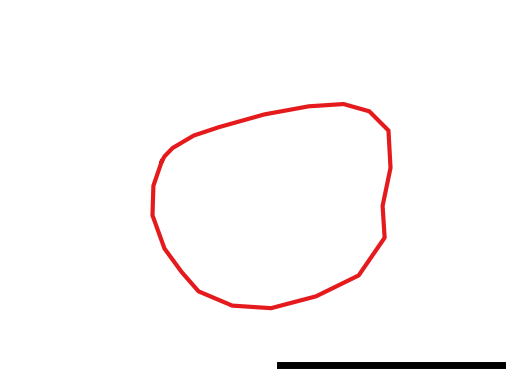

In [13]:
cell = mcells[0]
contour = get_soma_contour(cell)

x = list(contour[:, 0:1].flatten())
y = list(contour[:, 1:2].flatten())
x.append(x[0])
y.append(y[0])

plt.plot(x, y, color=mcolor, linewidth=3)

size = max(mdims[:,2].max(), hdims[:,2].max())
x0 = np.mean(x)
y0 = np.mean(y)
plt.xlim(x0 - size/2, x0 + size/2)
plt.ylim(y0 - size/2 - 2, y0 + size/2 + 2)
plt.plot([x0 + size/2, x0 + size/2 - 10], [y0 - size/2 - 1, y0 - size/2 - 1], 'k', linewidth=5)
plt.axis('off')
plt.savefig('images/somata-2.pdf')

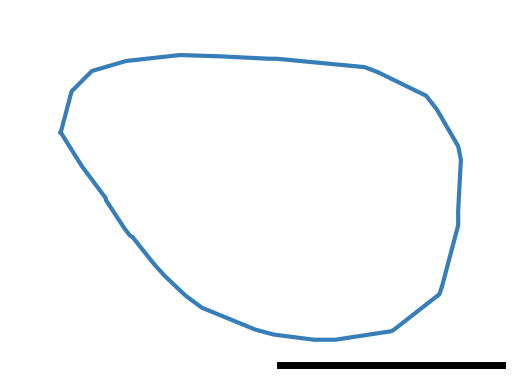

In [14]:
cell = hcells[0]
contour = get_soma_contour(cell)

x = list(contour[:, 0:1].flatten())
y = list(contour[:, 1:2].flatten())
x.append(x[0])
y.append(y[0])

plt.plot(x, y, color=hcolor, linewidth=3)

size = max(mdims[:,2].max(), hdims[:,2].max())
x0 = np.mean(x)
y0 = np.mean(y)
plt.xlim(x0 - size/2, x0 + size/2)
plt.ylim(y0 - size/2 - 2, y0 + size/2 + 2)
plt.plot([x0 + size/2, x0 + size/2 - 10], [y0 - size/2 - 1, y0 - size/2 - 1], 'k', linewidth=5)
plt.axis('off')
plt.savefig('images/somata-3.pdf')